In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/malaria-data/parasite_data/PV'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_73.png
/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_101.png
/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_70.png
/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_20.png
/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_71.png
/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_87.png
/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_4.png
/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_19.png
/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_67.png
/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_94.png
/kaggle/input/malaria-data/parasite_data/PV/val/mask/pv_54.png
/kaggle/input/malaria-data/parasite_data/PV/val/image/pv_94.jpg
/kaggle/input/malaria-data/parasite_data/PV/val/image/pv_54.jpg
/kaggle/input/malaria-data/parasite_data/PV/val/image/pv_71.jpg
/kaggle/input/malaria-data/parasite_data/PV/val/image/pv_70.jpg
/kaggle/input/malaria-data/parasite_data/PV/val/ima

In [10]:
import os
from typing import Tuple, List
import re
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
# import albumentations as album
# from albumentations.pytorch.transforms import ToTensorV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

In [11]:
# # Define the paths to your data directories
# train_img_folder = '/kaggle/input/malaria-data/parasite_data/PF/train/image/'
# train_mask_folder = '/kaggle/input/malaria-data/parasite_data/PF/train/mask/'

# val_img_folder = '/kaggle/input/malaria-data/parasite_data/PF/val/image/'
# val_mask_folder = '/kaggle/input/malaria-data/parasite_data/PF/val/mask/'

# test_img_folder = '/kaggle/input/malaria-data/parasite_data/PF/test/image/'
# test_mask_folder = '/kaggle/input/malaria-data/parasite_data/PF/test/mask/'

# Define the paths to your data directories
train_img_folder = '/kaggle/input/malaria-data/parasite_data/PV/train/image/'
train_mask_folder = '/kaggle/input/malaria-data/parasite_data/PV/train/mask/'

val_img_folder = '/kaggle/input/malaria-data/parasite_data/PV/val/image/'
val_mask_folder = '/kaggle/input/malaria-data/parasite_data/PV/val/mask/'

test_img_folder = '/kaggle/input/malaria-data/parasite_data/PV/test/image/'
test_mask_folder = '/kaggle/input/malaria-data/parasite_data/PV/test/mask/'

# # Define the paths to your data directories
# train_img_folder = '/kaggle/input/malaria-data/parasite_data/PM/train/image/'
# train_mask_folder = '/kaggle/input/malaria-data/parasite_data/PM/train/mask/'

# val_img_folder = '/kaggle/input/malaria-data/parasite_data/PM/val/image/'
# val_mask_folder = '/kaggle/input/malaria-data/parasite_data/PM/val/mask/'

# test_img_folder = '/kaggle/input/malaria-data/parasite_data/PM/test/image/'
# test_mask_folder = '/kaggle/input/malaria-data/parasite_data/PM/test/mask/'

# # Define the paths to your data directories
# train_img_folder = '/kaggle/input/malaria-data/parasite_data/PO/train/image/'
# train_mask_folder = '/kaggle/input/malaria-data/parasite_data/PO/train/mask/'

# val_img_folder = '/kaggle/input/malaria-data/parasite_data/PO/val/image/'
# val_mask_folder = '/kaggle/input/malaria-data/parasite_data/PO/val/mask/'

# test_img_folder = '/kaggle/input/malaria-data/parasite_data/PO/test/image/'
# test_mask_folder = '/kaggle/input/malaria-data/parasite_data/PO/test/mask/'

In [12]:
from traitlets.traitlets import validate
num_classes =1
image_train_data = []
label_train_data = []
images = sorted(os.listdir(train_img_folder))
for i, image_name in enumerate(images):
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(os.path.join(train_img_folder, image_name))
        # Resize the image to the desired shape if needed
        image = cv2.resize(image, (256, 256))
        image_train_data.append(image)

labels = sorted(os.listdir(train_mask_folder))
for i, label_name in enumerate(labels):
    if label_name.split('.')[1] == 'png':
        label = cv2.imread(os.path.join(train_mask_folder, label_name), cv2.IMREAD_GRAYSCALE)
        # Resize the label to the desired shape if needed
        label = cv2.resize(label, (256, 256))
        label_train_data.append(label)


# Convert to numpy arrays and normalize
image_train_data = np.array(image_train_data) / 255.0
label_train_data = np.array(label_train_data) / 255.0
label_train_data_single_channel = np.expand_dims(label_train_data, axis=-1)

print("Shape of image_train_data:", image_train_data.shape)
print("Shape of label_train_data:", label_train_data.shape)
print("Shape of label_train_data_single_channel:", label_train_data_single_channel.shape)



image_val_data = []
label_val_data = []
images = sorted(os.listdir(val_img_folder))
for i, image_name in enumerate(images):
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(os.path.join(val_img_folder, image_name))
        # Resize the image to the desired shape if needed
        image = cv2.resize(image, (256, 256))
        image_val_data.append(image)

labels = sorted(os.listdir(val_mask_folder))
for i, label_name in enumerate(labels):
    if label_name.split('.')[1] == 'png':
        label = cv2.imread(os.path.join(val_mask_folder, label_name), cv2.IMREAD_GRAYSCALE)
        # Resize the label to the desired shape if needed
        label = cv2.resize(label, (256, 256))
        label_val_data.append(label)

# Convert to numpy arrays and normalize
image_val_data = np.array(image_val_data) / 255.0
label_val_data = np.array(label_val_data) / 255.0
label_val_data_single_channel = np.expand_dims(label_val_data, axis=-1)

print("Shape of image_val_data:", image_val_data.shape)
print("Shape of label_val_data:", label_val_data.shape)
print("Shape of label_val_data_single_channel:", label_val_data_single_channel.shape)


image_test_data = []
label_test_data = []
images = sorted(os.listdir(test_img_folder))
for i, image_name in enumerate(images):
    if image_name.split('.')[1] == 'jpg':
        image = cv2.imread(os.path.join(test_img_folder, image_name))
        # Resize the image to the desired shape if needed
        image = cv2.resize(image, (256, 256))
        image_test_data.append(image)

labels = sorted(os.listdir(test_mask_folder))
for i, label_name in enumerate(labels):
    if label_name.split('.')[1] == 'png':
        label = cv2.imread(os.path.join(test_mask_folder, label_name), cv2.IMREAD_GRAYSCALE)
        # Resize the label to the desired shape if needed
        label = cv2.resize(label, (256, 256))
        label_test_data.append(label)

# image_train_data = np.array(image_train_data) / 255.0
# label_train_data = np.expand_dims(np.array(label_train_data), axis=-1) / 255.0

# Convert to numpy arrays and normalize
image_test_data = np.array(image_test_data) / 255.0
label_test_data = np.array(label_test_data) / 255.0
label_test_data_single_channel = np.expand_dims(label_test_data, axis=-1)
# label_test_data_onehot = to_categorical(label_test_data, num_classes)

print("Shape of image_test_data:", image_test_data.shape)
print("Shape of label_test_data:", label_test_data.shape)
print("Shape of label_test_data_single_channel:", label_test_data_single_channel.shape)


Shape of image_train_data: (91, 256, 256, 3)
Shape of label_train_data: (91, 256, 256)
Shape of label_train_data_single_channel: (91, 256, 256, 1)
Shape of image_val_data: (11, 256, 256, 3)
Shape of label_val_data: (11, 256, 256)
Shape of label_val_data_single_channel: (11, 256, 256, 1)
Shape of image_test_data: (12, 256, 256, 3)
Shape of label_test_data: (12, 256, 256)
Shape of label_test_data_single_channel: (12, 256, 256, 1)


In [13]:
print(image_train_data.shape, label_train_data.shape)


(91, 256, 256, 3) (91, 256, 256)


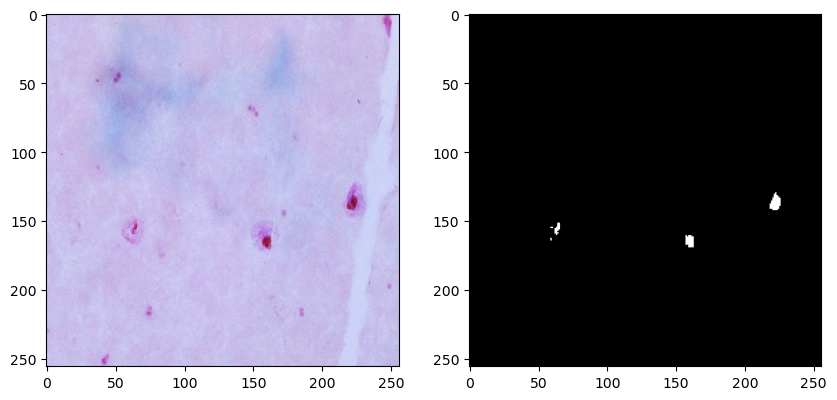

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(image_train_data[1])
ax[1].imshow(label_train_data[1], cmap='gray')
fig.show()


In [15]:
# n_classes = 1
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout,UpSampling2D
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import SensitivityAtSpecificity, SpecificityAtSensitivity, MeanIoU
# from sklearn.metrics import f1_score, precision_score, recall_score


# # Define the input shape based on the image size used in the data generator
# input_shape = (256, 256, 3)

# # # Define the U-Net model
# # s = tf.keras.Input(shape=input_shape)

# #U-net model
# s = Input((image_train_data.shape[1], image_train_data.shape[2], image_train_data.shape[3]))

# # Load a pretrained model (RESNET50) without top layers and freeze its layers
# pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# # Choose the index of the layer from which you want to fine-tune
# fine_tune_from_layer = 120  # Adjust this value as needed

# for layer in pretrained_model.layers[:fine_tune_from_layer]:
#     layer.trainable = False
# for layer in pretrained_model.layers[fine_tune_from_layer:]:
#     layer.trainable = True


# # Contraction path
# c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# c1 = Dropout(0.1)(c1)
# c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
# p1 = MaxPooling2D((2, 2))(c1)


# c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
# c2 = Dropout(0.1)(c2)
# c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
# p2 = MaxPooling2D((2, 2))(c2)

# c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# c3 = Dropout(0.2)(c3)
# c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
# p3 = MaxPooling2D((2, 2))(c3)

# c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# c4 = Dropout(0.2)(c4)
# c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
# p4 = MaxPooling2D(pool_size=(2, 2))(c4)

# c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# c5 = Dropout(0.3)(c5)
# c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# # Extract features from the pretrained model
# pretrained_features = pretrained_model(s)

# # Add a convolutional layer to the pretrained features
# pretrained_features_conv = Conv2D(256, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(pretrained_features)

# #Expansive path
# u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
# c6 = Dropout(0.2)(c6)
# c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = concatenate([u7, c3])
# c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# c7 = Dropout(0.2)(c7)
# c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = concatenate([u8, c2])
# c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
# c8 = Dropout(0.2)(c8)
# c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)



# u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = concatenate([u9, c1], axis=3)
# c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
# c9 = Dropout(0.1)(c9)
# c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


# # Resize the pretrained features to match the U-Net output size using UpSampling2D
# pretrained_features_resized = UpSampling2D(size=(32, 32))(pretrained_features_conv)

# # Combine the features from the pretrained model with the U-Net output
# combined_features = concatenate([pretrained_features_resized, c9], axis=-1)

# # Final Convolution layer
# outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(combined_features)

# # Create the final model
# model = Model(inputs=s, outputs=outputs)

# # Define MeanIoU metric outside the custom function
# mean_iou = MeanIoU(num_classes=2)

# # Compile the model with desired loss and optimizer
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', 
#               metrics=['accuracy',
#                        mean_iou                       
#                        ])

# model.summary()


# import numpy as np
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# # Define the early stopping and learning rate scheduler callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)



# history = model.fit(
#     x=np.array(image_train_data),
#     y=np.array(label_train_data),
#     validation_data=(image_val_data, label_val_data),
#     batch_size=16,
#     verbose=1,
#     epochs=300,
# #     callbacks=[early_stopping, reduce_lr],
# )





In [16]:
# n_classes =1
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout,Concatenate
# from tensorflow.keras.metrics import SensitivityAtSpecificity, SpecificityAtSensitivity, MeanIoU
# from tensorflow.keras.metrics import Precision, Recall
# from sklearn.metrics import f1_score


# # # Define the input shape based on the image size used in the data generator
# input_shape = (256, 256, 3)
# # Contracting Path (Encoder)
# inputs = Input(input_shape)

# conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
# conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
# pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)

# conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
# conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
# pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)

# conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
# conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
# pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv3)

# conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
# conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
# pool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv4)

# conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
# conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

# # Dropout Layer
# drop5 = Dropout(0.5)(conv5)

# # Expansive Path (Decoder)
# up6 = UpSampling2D(size=(2, 2))(drop5)
# upconv6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
# merge6 = Concatenate(axis=3)([conv4, upconv6])
# conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
# conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

# up7 = UpSampling2D(size=(2, 2))(conv6)
# upconv7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
# merge7 = Concatenate(axis=3)([conv3, upconv7])
# conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
# conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

# up8 = UpSampling2D(size=(2, 2))(conv7)
# upconv8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
# merge8 = Concatenate(axis=3)([conv2, upconv8])
# conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
# conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

# up9 = UpSampling2D(size=(2, 2))(conv8)
# upconv9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
# merge9 = Concatenate(axis=3)([conv1, upconv9])
# conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
# conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

# # # Output Layer
# outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

# model = Model(inputs=inputs, outputs=outputs)

# # Define MeanIoU metric outside the custom function
# mean_iou = MeanIoU(num_classes=2)

# # Compile the model with desired loss and optimizer
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', 
#               metrics=['accuracy',
#                        mean_iou
#                        ])
# model.summary()

# import numpy as np
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # Define the early stopping and learning rate scheduler callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)


# history = model.fit(
#     x=np.array(image_train_data),
#     y=np.array(label_train_data_single_channel),
#     validation_data=(image_val_data, label_val_data_single_channel),
#     batch_size=16,
#     verbose=1,
#     epochs=300
# #     callbacks=[early_stopping, reduce_lr],
# )


In [17]:
# n_classes =1
# import tensorflow as tf
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
# from tensorflow.keras.metrics import SensitivityAtSpecificity, SpecificityAtSensitivity, MeanIoU
# from tensorflow.keras.metrics import Precision, Recall
# from sklearn.metrics import f1_score

# # # Define the input shape based on the image size used in the data generator
# input_shape = (256, 256, 3)

# # Define the U-Net model
# s = tf.keras.Input(shape=input_shape)


# #Contraction path
# c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# c1 = Dropout(0.1)(c1)
# c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
# p1 = MaxPooling2D((2, 2))(c1)


# c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
# c2 = Dropout(0.1)(c2)
# c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
# p2 = MaxPooling2D((2, 2))(c2)

# c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# c3 = Dropout(0.2)(c3)
# c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
# p3 = MaxPooling2D((2, 2))(c3)

# c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# c4 = Dropout(0.2)(c4)
# c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
# p4 = MaxPooling2D(pool_size=(2, 2))(c4)

# c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# c5 = Dropout(0.3)(c5)
# c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# #Expansive path
# u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
# c6 = Dropout(0.3)(c6)
# c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = concatenate([u7, c3])
# c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# c7 = Dropout(0.2)(c7)
# c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = concatenate([u8, c2])
# c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
# c8 = Dropout(0.2)(c8)
# c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)


# u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = concatenate([u9, c1], axis=3)
# c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
# c9 = Dropout(0.1)(c9)
# c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

# model = Model(inputs=[s], outputs=[outputs])

# # Define MeanIoU metric outside the custom function
# mean_iou = MeanIoU(num_classes=2)

# # Compile the model with desired loss and optimizer
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', 
#               metrics=['accuracy', 
#                        mean_iou
#                        ])
# model.summary()

# import numpy as np
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # Define the early stopping and learning rate scheduler callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)


# history = model.fit(
#     x=np.array(image_train_data),
#     y=np.array(label_train_data_single_channel),
#     validation_data=(image_val_data, label_val_data_single_channel),
#     batch_size=16,
#     verbose=1,
#     epochs=300
# #     callbacks=[early_stopping, reduce_lr],
# )


In [18]:
# Define custom sensitivity and specificity functions
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(y_true * tf.round(y_pred))
    false_negatives = tf.reduce_sum(y_true * (1 - tf.round(y_pred)))
    return true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - tf.round(y_pred)))
    false_positives = tf.reduce_sum((1 - y_true) * tf.round(y_pred))
    return true_negatives / (true_negatives + false_positives + tf.keras.backend.epsilon())


In [19]:
n_classes =1
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout,Concatenate
from tensorflow.keras.metrics import SensitivityAtSpecificity, SpecificityAtSensitivity, MeanIoU
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from keras.losses import Huber

# # Define the input shape based on the image size used in the data generator
input_shape = (256, 256, 3)

# Define the U-Net model
s = tf.keras.Input(shape=input_shape)


#Contraction path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)


c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = MaxPooling2D(pool_size=(2, 2))(c5)

c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
p6  = MaxPooling2D(pool_size=(2, 2))(c6)

c7 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p6)
c7 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
p7 = p4 = MaxPooling2D(pool_size=(2, 2))(c7)

# Dropout Layer
drop7 = Dropout(0.5)(c7)

# Expansive Path (Decoder)
up8 = UpSampling2D(size=(2, 2))(drop7)
upconv8 = Conv2D(512, 2, activation='relu',kernel_initializer='he_normal', padding='same')(up8)
merge8 = Concatenate(axis=3)([c6, upconv8])
c8 = Conv2D(512, 3, activation='relu',kernel_initializer='he_normal', padding='same')(merge8)
c8 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal',padding='same')(c8)


up9 = UpSampling2D(size=(2, 2))(c8)
upconv9 = Conv2D(256, 2, activation='relu',kernel_initializer='he_normal', padding='same')(up9)
merge9 = Concatenate(axis=3)([c5, upconv9])
c9 = Conv2D(256, 3, activation='relu',kernel_initializer='he_normal', padding='same')(merge9)
c9 = Conv2D(256, 3, activation='relu',kernel_initializer='he_normal', padding='same')(c9)


up10 = UpSampling2D(size=(2, 2))(c9)
upconv10 = Conv2D(128, 2, activation='relu',kernel_initializer='he_normal', padding='same')(up10)
merge10 = Concatenate(axis=3)([c4, upconv10])
c10 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal',padding='same')(merge10)
c10 = Conv2D(128, 3, activation='relu',kernel_initializer='he_normal', padding='same')(c10)


up11 = UpSampling2D(size=(2, 2))(c10)
upconv11 = Conv2D(64, 2, activation='relu',kernel_initializer='he_normal', padding='same')(up11)
merge11 = Concatenate(axis=3)([c3, upconv11])
c11 = Conv2D(64, 3, activation='relu',kernel_initializer='he_normal', padding='same')(merge11)
c11 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal',padding='same')(c11)

up12 = UpSampling2D(size=(2, 2))(c11)
upconv12 = Conv2D(32, 2, activation='relu',kernel_initializer='he_normal', padding='same')(up12)
merge12 = Concatenate(axis=3)([c2, upconv12])
c12 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal',padding='same')(merge12)
c12 = Conv2D(32, 3, activation='relu',kernel_initializer='he_normal', padding='same')(c12)


up13 = UpSampling2D(size=(2, 2))(c12)
upconv13 = Conv2D(16, 2, activation='relu',kernel_initializer='he_normal', padding='same')(up13)
merge13 = Concatenate(axis=3)([c1, upconv13])
c13 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal',padding='same')(merge13)
c13 = Conv2D(16, 3, activation='relu',kernel_initializer='he_normal', padding='same')(c13)



outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c13)

model = Model(inputs=[s], outputs=[outputs])

# Define MeanIoU metric outside the custom function
mean_iou = MeanIoU(num_classes=2)

# Compile the model with desired loss and optimizer
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', 
              metrics=['accuracy', 
                       mean_iou,
                       sensitivity,
                       specificity,
#                        SensitivityAtSpecificity(specificity=0.1),  # Example sensitivity at 80% specificity
#                        SpecificityAtSensitivity(sensitivity=0.1),  # Example specificity at 70% sensitivity
                       Precision(),
                       Recall(),
#                        f1_score
                       ])
model.summary()

# import numpy as np
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # Define the early stopping and learning rate scheduler callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)


history = model.fit(
    x=np.array(image_train_data),
    y=np.array(label_train_data_single_channel),
    validation_data=(image_val_data, label_val_data_single_channel),
    batch_size=16,
    verbose=1,
    epochs=300
#     callbacks=[early_stopping, reduce_lr],
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

2023-08-23 04:35:47.321734: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - 30s 2s/step - loss: 0.0274 - accuracy: 0.9971 - mean_io_u: 0.4990 - sensitivity: 0.0000e+00 - specificity: 0.9995 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0208 - val_accuracy: 0.9971 - val_mean_io_u: 0.4989 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
6/6 [==============================] - 2s 259ms/step - loss: 0.0171 - accuracy: 0.9976 - mean_io_u: 0.4990 - sensitivity: 0.0000e+00 - specificity: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0184 - val_accuracy: 0.9971 - val_mean_io_u: 0.4989 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
6/6 [==============================] - 2s 261ms/step - loss: 0.0152 - accuracy: 0.9976 - mean_io_u: 0.4990 - sensitivity: 0.0000e+00 - specificity: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0172 - val_acc

In [20]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
model.save('unet.h5')

In [22]:
# from keras.utils import to_categorical

# # One-hot encode the label data
# label_train_data_onehot = to_categorical(label_train_data, num_classes)
# label_val_data_onehot = to_categorical(label_val_data, num_classes)


In [23]:
# # #  Evaluate the model on the test set
# test_results = model.evaluate(image_test_data, label_test_data, batch_size=16, verbose=1)

In [24]:
# Evaluate the model on the test set
test_results = model.evaluate(image_test_data, label_test_data_single_channel, batch_size=16, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.0196 - accuracy: 0.9979 - mean_io_u: 0.4996 - sensitivity: 0.2745 - specificity: 0.9993 - precision: 0.4289 - recall: 0.2675


In [25]:
# best_threshold = 0.001
# best_f1_score = 0.0

# threshold_range = np.arange(0.001, 1.0, 0.001)
# # Calculate custom metrics
# y_pred_test = model.predict(image_test_data)

# for threshold in threshold_range:
#     y_pred_binary_test = (y_pred_test >= threshold).astype(int)
#     label_test_binary = (label_test_data >= best_threshold).astype(int)
#     f1_test = f1_score(label_test_binary.reshape(-1), y_pred_binary_test.reshape(-1))
    
#     if f1_test > best_f1_score:
#         best_f1_score = f1_test
#         best_threshold = threshold

# print("Best Threshold:", best_threshold)
# print("Best F1 Score:", best_f1_score)


In [26]:
# Print the test results
print("Test Set Results:")
print("Loss:", test_results[0])
print("Accuracy:", test_results[1])
print("Mean IoU:", test_results[2])
print("Sensitivity:", test_results[3])
print("Specificity:", test_results[4])
print("Precision:", test_results[5])
print("Recall:", test_results[6])
# print("F1 score:", test_results[7])
def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0  # Avoid division by zero
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score
f1_score = calculate_f1_score(test_results[5],test_results[6])
print("F1 score:", f1_score)


Test Set Results:
Loss: 0.019624585285782814
Accuracy: 0.9978612065315247
Mean IoU: 0.4996059238910675
Sensitivity: 0.27449727058410645
Specificity: 0.9992902278900146
Precision: 0.42887699604034424
Recall: 0.26751166582107544
F1 score: 0.32949875816881774


In [27]:
# from sklearn.metrics import f1_score, precision_score, recall_score

# # Calculate custom metrics
# y_pred_test = model.predict(image_test_data)
# y_pred_binary_test = (y_pred_test >= best_threshold).astype(int)
# label_test_binary = (label_test_data >= best_threshold).astype(int)
# # Calculate F1, precision, recall using scikit-learn for the test set
# f1_test = f1_score(label_test_binary.reshape(-1), y_pred_binary_test.reshape(-1))
# precision_test = precision_score(label_test_binary.reshape(-1), y_pred_binary_test.reshape(-1))
# recall_test = recall_score(label_test_binary.reshape(-1), y_pred_binary_test.reshape(-1))

# # Print the test results
# print("Test Set Results:")
# print("Loss:", test_results[0])
# print("Accuracy:", test_results[1])
# print("Mean IoU:", test_results[2])
# print("F1 Score:", f1_test)
# print("Precision:", precision_test)
# print("Recall:", recall_test)

9
1/1 [==============================] - 0s 21ms/step


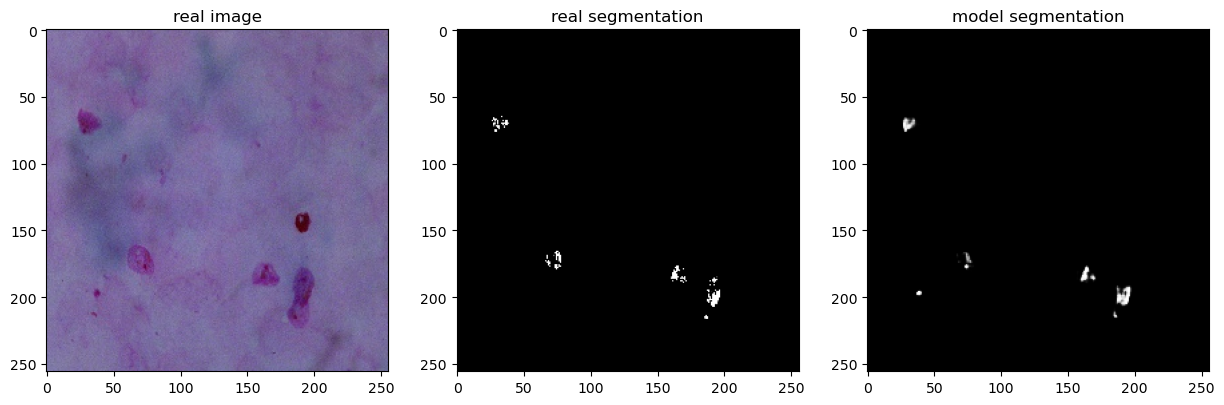

In [36]:
rndm_img = np.random.randint(0,len(image_test_data)+1)
print(rndm_img)
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(image_test_data[rndm_img])
ax[0].set_title('real image')
ax[1].imshow(label_test_data[rndm_img], cmap='gray')
ax[1].set_title('real segmentation')
test = np.expand_dims(image_test_data[rndm_img], axis=0)
ax[2].imshow(model.predict(test)[0], cmap='gray')
# predicted_masks = model.predict(test)[0]
# class_index = np.random.randint(0,num_classes)
# ax[2].imshow(predicted_masks[..., class_index], cmap='gray')
ax[2].set_title('model segmentation')
# Save the figure
plt.savefig('pf.png')
fig.show()

In [29]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Number of random images to plot
# num_images_to_plot = 5

# plt.figure(figsize=(15, 15 * num_images_to_plot))

# for i in range(num_images_to_plot):
#     rndm_img = np.random.randint(0, len(image_test_data))
    
#     # Get the original image, ground truth mask, and its corresponding predicted mask
#     test_image = image_test_data[rndm_img]
#     ground_truth_mask = label_test_data[rndm_img]
#     predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

#     plt.subplot(num_images_to_plot, 3, i * 3 + 1)
#     plt.imshow(test_image, cmap='gray')
#     plt.title('Original Image ' + str(i + 1))
#     plt.axis('off')

#     plt.subplot(num_images_to_plot, 3, i * 3 + 2)
#     plt.imshow(ground_truth_mask, cmap='gray')
#     plt.title('Ground Truth Segmentation ' + str(i + 1))
#     plt.axis('off')

#     plt.subplot(num_images_to_plot, 3, i * 3 + 3)
#     plt.imshow(predicted_mask, cmap='gray')
#     plt.title('Predicted Segmentation ' + str(i + 1))
#     plt.axis('off')

# plt.subplots_adjust(hspace=0.2)  # Adjust the vertical spacing between subplots
# plt.tight_layout()
# plt.savefig("grayscale_segmentation.png")
# plt.show()


In [30]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Get the original image, ground truth mask, and its corresponding predicted mask
# test_image = image_test_data[rndm_img]
# ground_truth_mask = label_test_data[rndm_img]
# predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# # Apply overlay only where the predicted mask is above a certain threshold
# overlay_mask = np.zeros_like(predicted_mask)
# overlay_mask[predicted_mask >= best_threshold] = 1  # Create a binary mask

# # Apply the overlay mask to the original image for predicted overlay
# overlay_image_predicted = test_image * (1 - overlay_mask) + overlay_mask * [255, 255, 0]  # Red overlay color

# # Apply the overlay mask to the original image for ground truth overlay
# overlay_image_ground_truth = test_image * (1 - ground_truth_mask[..., np.newaxis]) + ground_truth_mask[..., np.newaxis] * [0, 255, 0]  # Green overlay color

# # Plot the original image, ground truth overlay, and predicted overlay
# plt.figure(figsize=(15, 15))

# # Display the original image
# plt.subplot(1, 3, 1)
# plt.imshow(test_image)
# plt.title('Original Image')
# plt.axis('off')

# # Display the ground truth overlay
# plt.subplot(1, 3, 2)
# plt.imshow(overlay_image_ground_truth)
# plt.title('Ground Truth Overlay')
# plt.axis('off')

# # Display the predicted overlay
# plt.subplot(1, 3, 3)
# plt.imshow(overlay_image_predicted)
# plt.title('Predicted Segmentation Overlay')
# plt.axis('off')

# plt.savefig("pf_overlay.png")

# plt.tight_layout()
# plt.show()


In [31]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Number of random images to plot
# num_images_to_plot = 5

# plt.figure(figsize=(15, 15 * num_images_to_plot))

# for i in range(num_images_to_plot):
#     rndm_img = np.random.randint(0, len(image_test_data))
    
#     # Get the original image, ground truth mask, and its corresponding predicted mask
#     test_image = image_test_data[rndm_img]
#     ground_truth_mask = label_test_data[rndm_img]
#     predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

#     # Apply overlay only where the predicted mask is above a certain threshold
#     overlay_mask = np.zeros_like(predicted_mask)
#     overlay_mask[predicted_mask >= 0.1] = 1  # Create a binary mask

#     # Apply the overlay mask to the original image for predicted overlay
#     overlay_image_predicted = test_image * (1 - overlay_mask) + overlay_mask * [255, 255, 0]  # Yellow overlay color

#     # Apply the overlay mask to the original image for ground truth overlay
#     overlay_image_ground_truth = test_image * (1 - ground_truth_mask[..., np.newaxis]) + ground_truth_mask[..., np.newaxis] * [0, 255, 0]  # Green overlay color
    
#     plt.subplot(num_images_to_plot, 3, i * 3 + 1)
#     plt.imshow(test_image)
#     plt.title('Original Image ' + str(i + 1))
#     plt.axis('off')

#     plt.subplot(num_images_to_plot, 3, i * 3 + 2)
#     plt.imshow(overlay_image_ground_truth)
#     plt.title('Ground Truth Overlay ' + str(i + 1))
#     plt.axis('off')

#     plt.subplot(num_images_to_plot, 3, i * 3 + 3)
#     plt.imshow(overlay_image_predicted)
#     plt.title('Predicted Overlay ' + str(i + 1))
#     plt.axis('off')

# plt.subplots_adjust(hspace=0.2)  # Adjust the vertical spacing between subplots
# plt.tight_layout()
# plt.savefig("image_ground_truth_predicted.png")
# plt.show()


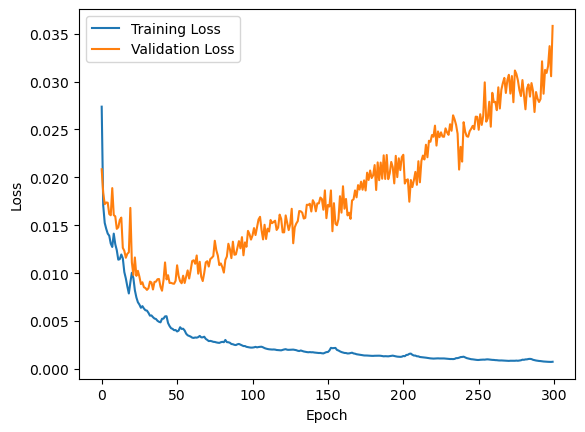

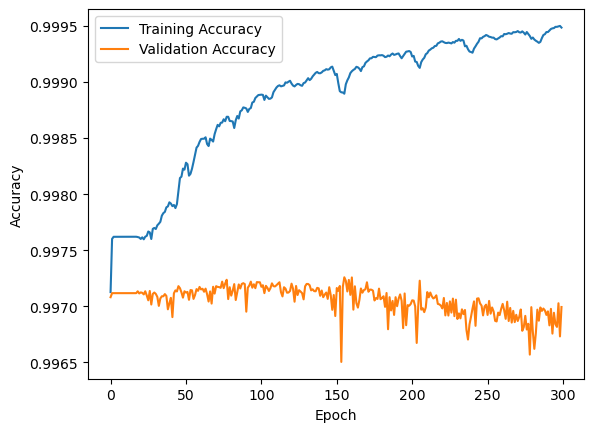

In [32]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss.png")
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("accuracy.png")
plt.show()